Ada 8 model yang dikomparasikan pada notebook ini, yaitu Logistic Regression, Support Vector Machine, Bernoulli Naive Bayes, Decision Tree Classifier, Random Forest Classifier, XGBoost Classifier, Catboost Classifier, dan Convolutional Neural Network.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import joblib

from sklearn.metrics import r2_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [119]:
column_name = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [120]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1', names=column_name)

In [121]:
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [122]:
df.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

In [123]:
df.shape

(1600000, 2)

In [ ]:
# Sampling 15000 sentimen positif dan 15000 sentimen negatif
df_positive = df[df['sentiment'] == 4].sample(n=15000, random_state=42)
df_negative = df[df['sentiment'] == 0].sample(n=15000, random_state=42)
df = pd.concat([df_positive, df_negative], ignore_index=True)

In [416]:
df['sentiment'].value_counts()

4    15000
0    15000
Name: sentiment, dtype: int64

In [417]:
df['sentiment'] = df['sentiment'].replace(4, 1)

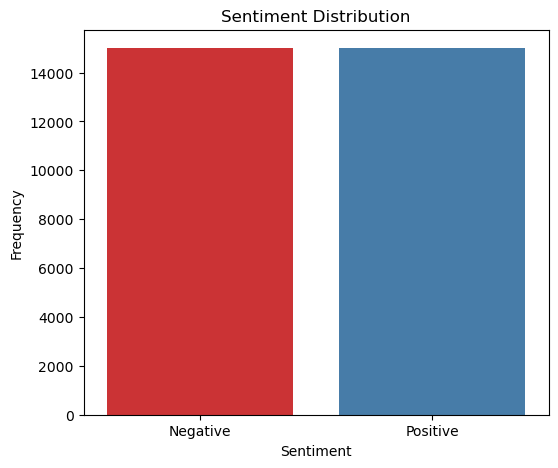

In [418]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set1')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(range(len(sentiment_counts)), ['Negative', 'Positive'])
plt.show()

Tampak distribusi kelasnya seimbang sehingga tidak membutuhkan imbalanced data handling.

In [419]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
def cleanText(text):
    cleanedText = []

    links = r'http\S+|www\S+|https\S+'
    userPattern = '@[^\s]+'
    apostrophe = r"'"
    nonWord = r'\W'
    singleCharacter = r'\s+[a-zA-Z]\s+'
    caretSymbol = r'\^[a-zA-Z]\s+'
    alphabet = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    multiSpace = r'\s+'

    text = text.lower()

    text = re.sub(links, ' ', text, flags=re.MULTILINE)

    text = re.sub(userPattern,' ', text)
    text = re.sub(apostrophe, '', text)
    text = re.sub(nonWord, ' ', text)
    text = re.sub(singleCharacter, ' ', text)
    text = re.sub(caretSymbol, ' ', text) 
    text = re.sub(alphabet, " ", text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    text = re.sub(multiSpace, ' ', text, flags=re.I)
    text = text.strip()
    
    wordLemm = WordNetLemmatizer()

    words = ''
    for word in text.split():
        if len(word)>1:
            if word != 'was':
                word = wordLemm.lemmatize(word)
            words += (word+' ')

    cleanedText.append(words)

    lemmatizedText = ' '.join(cleanedText)

    words = lemmatizedText.split()

    custom_stopwords = {'amp', 'quot', 'im', 'day'}
    words = [word for word in words if word not in custom_stopwords]

    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [423]:
df['cleaned_text'] = df['text'].apply(lambda x: cleanText(x))

In [ ]:
# df.to_csv('cleaned_data_30k_deploy.csv', index=False)

In [ ]:
# df = pd.read_csv('cleaned_data_30k_deploy.csv')

In [535]:
df.isnull().sum()

sentiment        0
text             0
cleaned_text    69
dtype: int64

In [536]:
df.dropna(inplace=True)

In [539]:
X = df['cleaned_text']
y = df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [442]:
# # Save tfidf using pickle
# with open('tfidf_vectorizer_base.pkl', 'wb') as f:
#     pickle.dump(tfidf_vectorizer, f)

In [542]:
X_train_tfidf.shape, X_test_tfidf.shape

((23944, 50000), (5987, 50000))

In [446]:
nama_model_sentiment = []
scoreTrainArr = []
scoreTestArr = []
precisionArr = []
recallArr = []
f1Arr = []

def pred_model(model, X_train, y_train, X_test, y_test, nama_model):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    scoreTrain = accuracy_score(y_train, y_pred_train)
    scoreTest = accuracy_score(y_test, y_pred_test)
    
    nama_model_sentiment.append(nama_model)
    scoreTrainArr.append(scoreTrain)
    scoreTestArr.append(scoreTest)
    
    print("=====================================================")
    print("Evaluasi Akurasi Model:")
    print("Training Accuracy :", scoreTrain)
    print("Testing Accuracy :", scoreTest)
    
    print("=====================================================")
    
    print("\nClassification report untuk data test:")
    cr = classification_report(y_test, y_pred_test)
    print(cr)

    cr2 = classification_report(y_test, y_pred_test, output_dict=True)
    precisionArr.append(cr2['macro avg']['precision'])
    recallArr.append(cr2['macro avg']['recall'])
    f1Arr.append(cr2['macro avg']['f1-score'])
    
    print("=====================================================")
    
    confusion_matrix_percent = confusion_matrix(y_test, y_pred_test)
    confusion_matrix_df = pd.DataFrame(confusion_matrix_percent, index=model.classes_, columns=model.classes_)

    plt.figure()
    heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='.0f', cmap='YlGnBu')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,  fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0,  fontsize=14)

    plt.title('Confusion Matrix untuk Data Test', fontsize=18, color='darkblue')
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()

In [448]:
clf_logreg = LogisticRegression(random_state=42).fit(X_train_tfidf, y_train)
clf_svm = SVC(kernel='linear', random_state=42).fit(X_train_tfidf, y_train)
clf_bnb = BernoulliNB().fit(X_train_tfidf, y_train)
clf_dt = DecisionTreeClassifier(random_state=42).fit(X_train_tfidf, y_train)
clf_rf = RandomForestClassifier(random_state=42).fit(X_train_tfidf, y_train)
clf_xgboost = XGBClassifier(random_state=42).fit(X_train_tfidf, y_train) 
clf_catboost = CatBoostClassifier(random_state=42, verbose=0).fit(X_train_tfidf, y_train)

Evaluasi Akurasi Model:
Training Accuracy : 0.8792916666666667
Testing Accuracy : 0.7746666666666666

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      2952
           1       0.79      0.76      0.77      3048

    accuracy                           0.77      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.78      0.77      0.77      6000



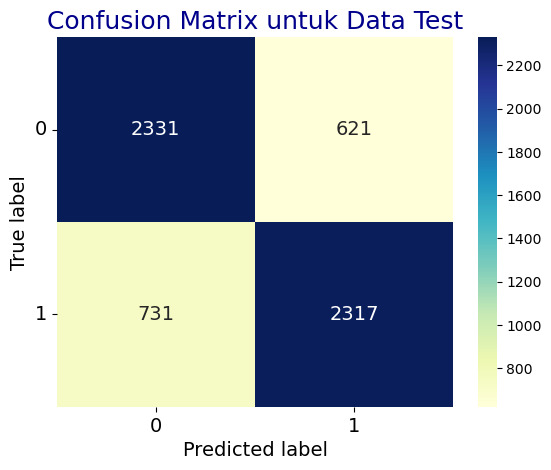

In [449]:
pred_model(clf_logreg, X_train_tfidf, y_train, X_test_tfidf, y_test, 'Logistic Regression')

Evaluasi Akurasi Model:
Training Accuracy : 0.9297916666666667
Testing Accuracy : 0.7745

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      2952
           1       0.79      0.76      0.77      3048

    accuracy                           0.77      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.77      0.77      0.77      6000



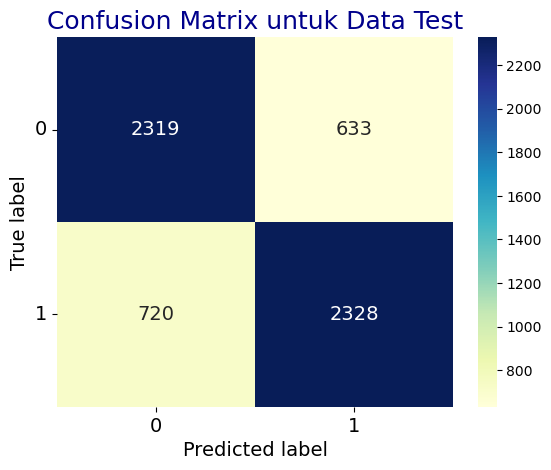

In [450]:
pred_model(clf_svm, X_train_tfidf, y_train, X_test_tfidf, y_test, 'SVM')

Evaluasi Akurasi Model:
Training Accuracy : 0.9045
Testing Accuracy : 0.755

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      2952
           1       0.75      0.78      0.76      3048

    accuracy                           0.76      6000
   macro avg       0.76      0.75      0.75      6000
weighted avg       0.76      0.76      0.75      6000



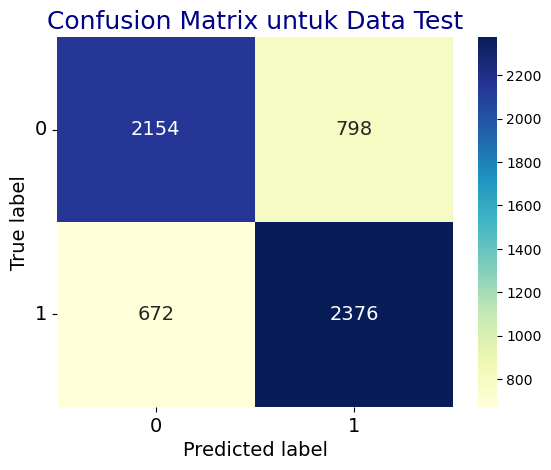

In [451]:
pred_model(clf_bnb, X_train_tfidf, y_train, X_test_tfidf, y_test, 'Bernoulli NB')

Evaluasi Akurasi Model:
Training Accuracy : 0.9972916666666667
Testing Accuracy : 0.6823333333333333

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      2952
           1       0.68      0.70      0.69      3048

    accuracy                           0.68      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.68      0.68      0.68      6000



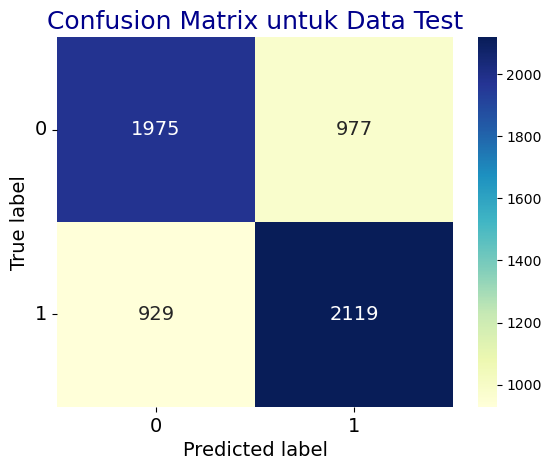

In [452]:
pred_model(clf_dt, X_train_tfidf, y_train, X_test_tfidf, y_test, 'Decision Tree')

Evaluasi Akurasi Model:
Training Accuracy : 0.9972916666666667
Testing Accuracy : 0.7505

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2952
           1       0.77      0.73      0.75      3048

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000



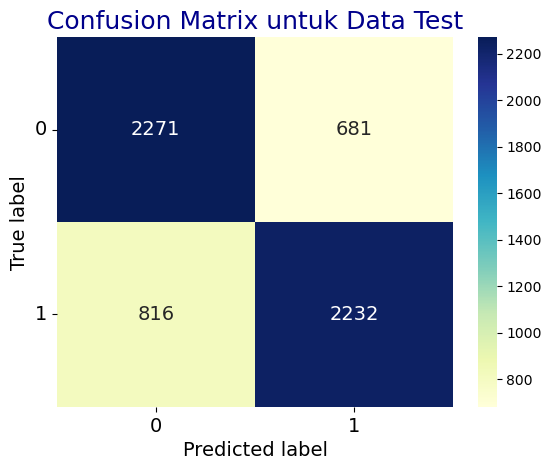

In [453]:
pred_model(clf_rf, X_train_tfidf, y_train, X_test_tfidf, y_test, 'Random Forest')

Evaluasi Akurasi Model:
Training Accuracy : 0.8210416666666667
Testing Accuracy : 0.7428333333333333

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2952
           1       0.74      0.77      0.75      3048

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000



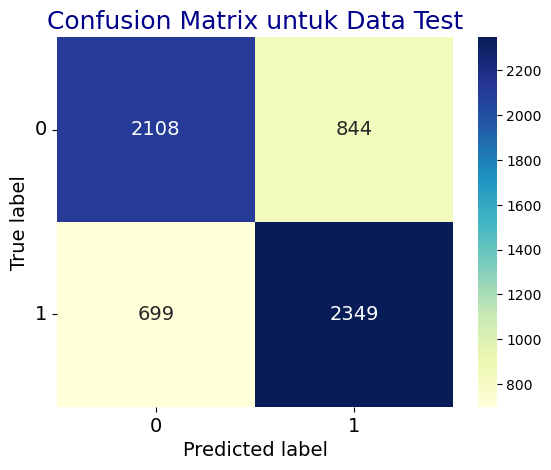

In [454]:
pred_model(clf_xgboost, X_train_tfidf, y_train, X_test_tfidf, y_test, 'XGBoost')

Evaluasi Akurasi Model:
Training Accuracy : 0.8165
Testing Accuracy : 0.7581666666666667

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2952
           1       0.76      0.77      0.76      3048

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000



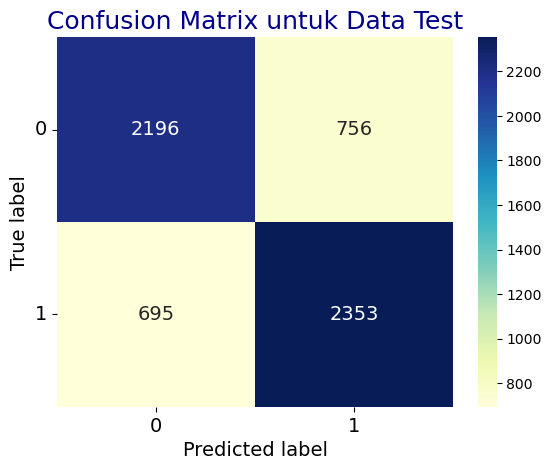

In [455]:
pred_model(clf_catboost, X_train_tfidf, y_train, X_test_tfidf, y_test, 'CatBoost')

In [ ]:
# Convolutional Neural Network (CNN)

# Tokenisasi
max_words = 50000  
max_len = 50 

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Mengatur padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

# Pembuatan model CNN
model_cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax') 
])

# Compile model
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
epochs = 2 # Hanya menggunakan 2 epoch karena saya sudah mencoba jika lebih dari itu, akurasi validasi akan menurun.
batch_size = 32

history = model_cnn.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test), verbose=1)

# Menampilkan loss dan akurasi model
train_accuracy = history.history['accuracy'][-1]
loss, test_accuracy = model_cnn.evaluate(X_test_pad, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/2
749/749 [==============================] - 6s 7ms/step - loss: 0.5451 - accuracy: 0.7195 - val_loss: 0.4819 - val_accuracy: 0.7700
Epoch 2/2
188/188 [==============================] - 0s 2ms/step - loss: 0.5046 - accuracy: 0.7737
Test Accuracy: 0.7737


In [ ]:
# Prediksi dan evaluasi
y_pred_prob = model_cnn.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

cr_cnn = classification_report(y_test, y_pred, output_dict=True)

nama_model_sentiment.append('CNN')
scoreTrainArr.append(train_accuracy)
scoreTestArr.append(cr_cnn['accuracy'])
precisionArr.append(cr_cnn['macro avg']['precision'])
recallArr.append(cr_cnn['macro avg']['recall'])
f1Arr.append(cr_cnn['macro avg']['f1-score'])

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

  1/188 [..............................] - ETA: 4s

188/188 [==============================] - 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2993
           1       0.79      0.75      0.77      2994

    accuracy                           0.77      5987
   macro avg       0.77      0.77      0.77      5987
weighted avg       0.77      0.77      0.77      5987



In [557]:
df_result_score_sentiment = pd.DataFrame({
    'Model': nama_model_sentiment,
    'Train Score': scoreTrainArr,
    'Test Score': scoreTestArr,
    'Precision': precisionArr,
    'Recall': recallArr,
    'F1 Score': f1Arr
})

In [558]:
df_result_score_sentiment = df_result_score_sentiment.sort_values(by='F1 Score', ascending=False)
df_result_score_sentiment

,Model,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,0.879292,0.774667,0.774949,0.774902,0.774665
1,SVM,0.929792,0.774500,0.774650,0.774674,0.774499
7,CNN,0.846600,0.773676,0.774217,0.773680,0.773566
6,CatBoost,0.816500,0.758167,0.758217,0.757942,0.758001
2,Bernoulli NB,0.904500,0.755000,0.755395,0.754601,0.754664
4,Random Forest,0.997292,0.750500,0.750943,0.750796,0.750489
5,XGBoost,0.821042,0.742833,0.743326,0.742381,0.742418
3,Decision Tree,0.997292,0.682333,0.682264,0.682124,0.682150


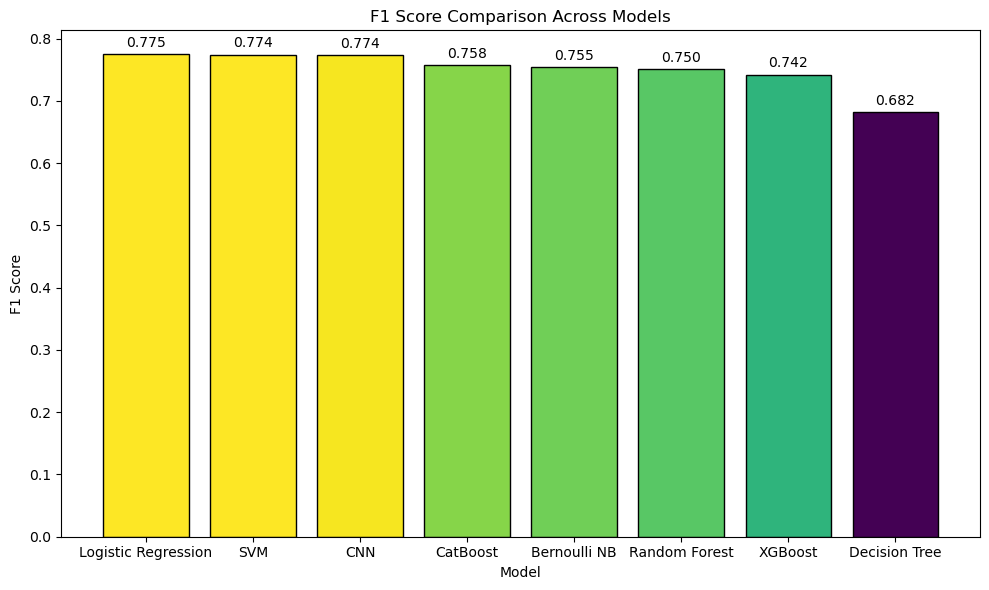

In [559]:
norm = plt.Normalize(df_result_score_sentiment['F1 Score'].min(), df_result_score_sentiment['F1 Score'].max())
colors = plt.cm.viridis(norm(df_result_score_sentiment['F1 Score'].values))

plt.figure(figsize=(10, 6))
bars = plt.bar(df_result_score_sentiment['Model'], df_result_score_sentiment['F1 Score'], edgecolor='black', color=colors)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), 
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Models')
plt.tight_layout()
plt.show()

In [458]:
# # Save logistic regression model using pickle
# with open('logistic_regression_model_base.pkl', 'wb') as f:
#     pickle.dump(clf_logreg, f)